Notes:
- Jalankan satu persatu
- Jalankan sesuai dengan kebutuhan model

---
Berikut list model dalam python notebook ini:
1.   Neural Prophet
2.   Facebook Prophet




# 0. Setup

## 0.1 Install Neural Prophet

In [96]:
# !git clone https://github.com/ourownstory/neural_prophet.git

%cd neural_prophet

# !pip install .

[Errno 2] No such file or directory: 'neural_prophet'
/Users/efraimwijaya/Developer/github/skripsi-forecasting-neural-prophet/new-neural-prophet/neural_prophet


In [97]:
# !pip install livelossplot

In [98]:
!git checkout tags/0.3.1

HEAD is now at badb2d7 Auto epochs: wider range of auto-epochs: 10-1000 (#570)


## 0.2 Install Facebook Prophet

In [99]:
!pip install pystan==2.19.1.1
!pip install cmdstanpy==0.9.5
!pip install prophet

  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.1
    Uninstalling cmdstanpy-1.0.1:
      Successfully uninstalled cmdstanpy-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1 requires cmdstanpy>=1.0.1, but you have cmdstanpy 0.9.5 which is incompatible.
  Using cached cmdstanpy-1.0.1-py3-none-any.whl (69 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


## 0.3 Import Module

In [289]:
# neural prophet module
from neuralprophet import NeuralProphet

# facebook prophet module
from prophet import Prophet
import torch

# data manipulation
import numpy as np
import pandas as pd

# plotting / visualization
from matplotlib import pyplot as plt
import seaborn as sns

# classical machine learning models / basic calculation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [2]:
# in case random of gradient descent we use seed
from neuralprophet import set_random_seed
set_random_seed(0)

In [102]:
!pwd
!ls

/Users/efraimwijaya/Developer/github/skripsi-forecasting-neural-prophet/new-neural-prophet/neural_prophet
CODE_OF_CONDUCT.md              model
CONTRIBUTING.md                 neuralprophet
COVID_19_Neural_Prophet_8.ipynb neuralprophet.egg-info
LICENSE                         notes
MANIFEST.in                     pyproject.toml
README.md                       requirements.txt
build                           scripts
codecov.yml                     setup.py
datasets                        tests
docs                            tutorials
mkdocs.yml


## 1.1 Read Datasets

In [3]:
# data location
data_location = "./datasets/statistik-harian-2022.xlsx"
# data_location = "./datasets/with23jul.xlsx"

# read data 
df = pd.read_excel(
    data_location,
    usecols=['Tanggal','Kasus harian'],
    dtype={
        'Kasus harian': 'int',
    },
    converters= {
        'Tanggal': pd.to_datetime
    }
)

# rename to ds, y 
df = pd.DataFrame(list(zip(df["Tanggal"], df["Kasus harian"])),
               columns =['ds', 'y'])

In [104]:
df.tail()

ds     y
771 2022-04-13  1551
772 2022-04-14   833
773 2022-04-15   922
774 2022-04-16   602
775 2022-04-17   607

In [ ]:
# For Neural Prophet
covidVariantNeuralProphet = pd.DataFrame({ # COVID-19 variant
    'event': 'covidVariantNeuralProphet',
    'ds': pd.to_datetime([
        '2021-05-01', # Alpha, Beta, Delta
        '2021-12-01', # Omnicorn
        '2022-03-15', # Son of omnicorn
    ]),
    'lower_window': 0, # Before Event
    'upper_window': 30*3, # After Event
})

hariRayaNeuralProphet = pd.DataFrame({ # manual set hari raya as holidays
    'event': 'hariRayaNeuralProphet',
    'ds': pd.to_datetime([
        # 2020
        '2020-01-01', '2020-01-25', '2020-03-22',
        '2020-03-25', '2020-04-10', '2020-05-01',
        '2020-05-07', '2020-05-21', '2020-05-22',
        '2020-05-24', '2020-05-25', '2020-06-01',
        '2020-07-31', '2020-08-17', '2020-08-21',
        '2020-10-28', '2020-10-29', '2020-10-30',
        '2020-12-09', '2020-12-24', '2020-12-25',
        '2020-12-31',
        # 2021
        '2021-01-01', '2021-02-12', '2021-03-11',
        '2021-03-14', '2021-04-02', '2021-05-01',
        '2021-05-12', '2021-05-13', '2021-05-14',
        '2021-05-26', '2021-06-01', '2021-07-20', 
        '2021-08-11', '2021-08-17', '2021-10-20', 
        '2021-12-25', '2021-12-31',
        # 2022
        '2022-01-01', '2022-02-01', '2022-02-28',
        '2022-03-03', '2022-04-15', '2022-05-01',
        '2022-05-02', '2022-05-03', '2022-05-16',
        '2022-05-26', '2022-06-01', '2022-07-09', 
        '2022-07-30', '2022-08-17', '2022-10-08', 
        '2022-12-25', '2022-12-31',
        # 2023
        '2023-01-01', '2023-01-22', '2023-02-18',
        '2023-03-22', '2023-04-07', '2023-04-22',
        '2023-04-23', '2023-05-01', '2023-05-06',
        '2023-05-18', '2023-06-01', '2023-06-29',
        '2023-07-19', '2023-08-17', '2023-09-27',
        '2023-12-25',     

    ]),
    'lower_window': 0, # Before Event
    'upper_window': 1, # After Event
})

# merge data as one history event
df_event_neural_prophet = pd.concat((covidVariantNeuralProphet, hariRayaNeuralProphet))

# For Facebook Prophet
covidVariantFacebookProphet = pd.DataFrame({ # COVID-19 variant
    'holiday': 'covidVariantFacebookProphet',
    'ds': pd.to_datetime([
        '2021-05-01', # Alpha, Beta, Delta
        '2021-12-01', # Omnicorn
        '2022-03-15', # Son of omnicorn
    ]),
    'lower_window': 0,
    'upper_window': 30*3,
})

hariRayaFacebookProphet = pd.DataFrame({ # manual set hari raya as holidays
    'holiday': 'hariRayaFacebookProphet',
    'ds': pd.to_datetime([
        # 2020
        '2020-01-01', '2020-01-25', '2020-03-22',
        '2020-03-25', '2020-04-10', '2020-05-01',
        '2020-05-07', '2020-05-21', '2020-05-22',
        '2020-05-24', '2020-05-25', '2020-06-01',
        '2020-07-31', '2020-08-17', '2020-08-21',
        '2020-10-28', '2020-10-29', '2020-10-30',
        '2020-12-09', '2020-12-24', '2020-12-25',
        '2020-12-31',
        # 2021
        '2021-01-01', '2021-02-12', '2021-03-11',
        '2021-03-14', '2021-04-02', '2021-05-01',
        '2021-05-12', '2021-05-13', '2021-05-14',
        '2021-05-26', '2021-06-01', '2021-07-20', 
        '2021-08-11', '2021-08-17', '2021-10-20', 
        '2021-12-25', '2021-12-31',
        # 2022
        '2022-01-01', '2022-02-01', '2022-02-28',
        '2022-03-03', '2022-04-15', '2022-05-01',
        '2022-05-02', '2022-05-03', '2022-05-16',
        '2022-05-26', '2022-06-01', '2022-07-09', 
        '2022-07-30', '2022-08-17', '2022-10-08', 
        '2022-12-25', '2022-12-31',
        # 2023
        '2023-01-01', '2023-01-22', '2023-02-18',
        '2023-03-22', '2023-04-07', '2023-04-22',
        '2023-04-23', '2023-05-01', '2023-05-06',
        '2023-05-18', '2023-06-01', '2023-06-29',
        '2023-07-19', '2023-08-17', '2023-09-27',
        '2023-12-25',     

    ]),
    'lower_window': 0,
    'upper_window': 1,
})

df_event_facebook_prophet = pd.concat((covidVariantFacebookProphet, hariRayaFacebookProphet))

# 6. Save Model


In [102]:
import pickle

In [ ]:
# 821
with open('/content/model_7.pkl', "wb") as f:
   pickle.dump(m, f)

In [106]:
model = pickle.load(open('./model/model_7.pkl', 'rb'))

AttributeError: Can't get attribute 'MissingDataHandling' on <module 'neuralprophet.configure' from '/Users/efraimwijaya/Developer/github/skripsi-forecasting-neural-prophet/new-neural-prophet/neural_prophet/neuralprophet/configure.py'>

In [ ]:
print("DONE")

DONE


# 7. EDA

In [108]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 2.9 MB/s eta 0:00:00m eta 0:00:010:00:01


In [ ]:
import pandas as pd

# data location
data_location = "./datasets/with23jul.xlsx"

# read data 
df = pd.read_excel(
    data_location,
    usecols=['Tanggal','Kasus harian'],
    dtype={
        'Kasus harian': 'int',
    },
    converters= {
        'Tanggal': pd.to_datetime
    }
)

# rename to ds, y 
df = pd.DataFrame(list(zip(df["Tanggal"], df["Kasus harian"])),
               columns =['ds', 'y'])



In [ ]:
df = df.set_index('ds')

In [109]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], name='Actual',))
# fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['yhat1'], name='Predicted',))
# fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['event_covidVariantNeuralProphet'], name='Covid Variant',))
# fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['event_hariRayaNeuralProphet'], name='Hari Raya',))

fig.show()

# 8. Inference with new data

## 8.1 Neural Prophet

In [42]:
metrics = ['SmoothL1Loss', 'MAE', 'RMSE']

params_neural_prophet_nn = {
    # Data Preprocessing
    # 'normalize' : 'minmax',
    'impute_missing' : True,
    
    # Trend
    # 'growth' : 'off', 
    'n_changepoints' : 30,
    # 'changepoints_range' : 0.4, 
    # 'trend_reg' : 0,

    # Seasonality
    'yearly_seasonality' : True, 
    'weekly_seasonality' : True, 
    'daily_seasonality' : False, 
    'seasonality_mode' : 'multiplicative', 
    # 'seasonality_reg' : 0, # regularize seasonal

    # AR-Net (Classical AR)
    'n_lags' : 60,
    'n_forecasts' : 30,
    # 'ar_reg' : 0.7, # regularize ar

    # Neural Network + (Classical AR)
    'batch_size' : 30, 
    'epochs' : 500,
    'num_hidden_layers' : 4,
    'd_hidden' : 16, 
    'learning_rate' : 0.005, 
    'loss_func' : 'mae',
    # 'collect_metrics' : True,
}

In [26]:
# set model with params
m = NeuralProphet(
    **params_neural_prophet_nn
)

# add history event
m = m.add_events(["covidVariantNeuralProphet", "hariRayaNeuralProphet"])
concat_df_event_neural_prophet = m.create_df_with_events(df, df_event_neural_prophet)

In [241]:
# split size data concat_df_event_neural_prophet
df_size = concat_df_event_neural_prophet['y'].size
df_train_size = int(df_size*0.8)
df_test_size = int(df_size*0.2)

# set size of train datasets
df_train_neural_prophet = concat_df_event_neural_prophet[:df_train_size]

# as train datasets make it to string date
date = df_train_neural_prophet['ds'].tail(1)
date = date.to_string(index=False)
# date

# split data as data time
df_train_neural_prophet = concat_df_event_neural_prophet[df['ds'] < pd.Timestamp(date)]
df_test_neural_prophet = concat_df_event_neural_prophet[df['ds'] >= pd.Timestamp(date)]

df_train_neural_prophet.tail()

ds    y  covidVariantNeuralProphet  hariRayaNeuralProphet
668 2021-12-31  180                        0.0                    1.0
669 2022-01-01  274                        0.0                    1.0
670 2022-01-02  174                        0.0                    0.0
671 2022-01-03  265                        0.0                    0.0
672 2022-01-04  299                        0.0                    0.0

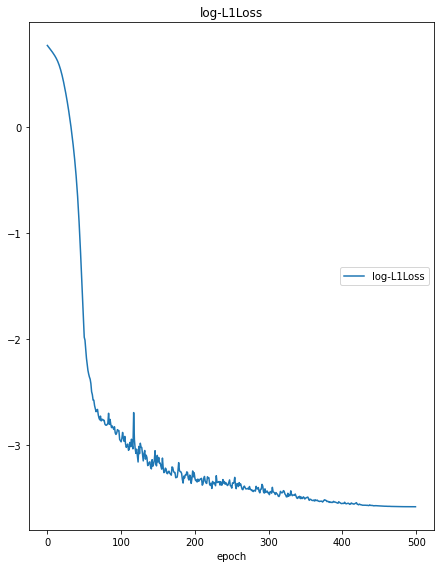

log-L1Loss
	log-L1Loss       	 (min:   -3.583, max:    0.772, cur:   -3.583)


In [27]:
# # train data
metrics_neural_prophet = m.fit(
    df=concat_df_event_neural_prophet, 
    freq='D', 
    # validation_df=df_test_neural_prophet, 
    progress='plot',
)

In [28]:
metrics_neural_prophet.describe().loc[["mean", "std", "min", "max"]]

L1Loss           MAE           RMSE  RegLoss
mean  0.164996   5917.898491    8753.171590      0.0
std   0.432290  15504.944555   20407.889582      0.0
min   0.027780    996.397652    2254.970939      0.0
max   2.165030  77653.136175  102533.600062      0.0

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.763% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /Users/efraimwijaya/Developer/github/skripsi-forecasting-neural-prophet/new-neural-prophet/neural_prophet/neuralprophet/forecaster.py:1665: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.771% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.771% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 1 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 1 NaN values in 

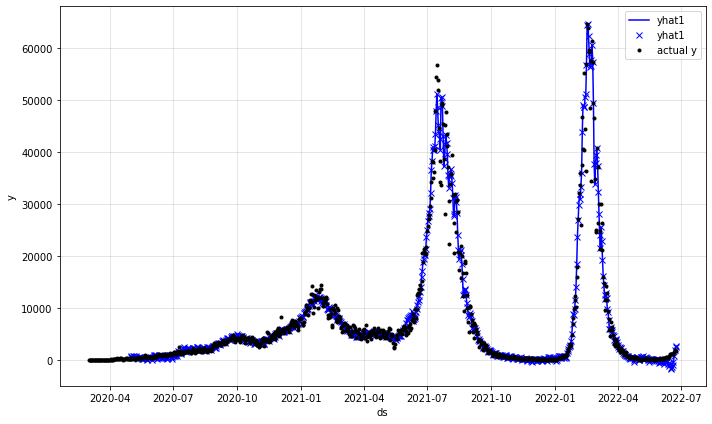

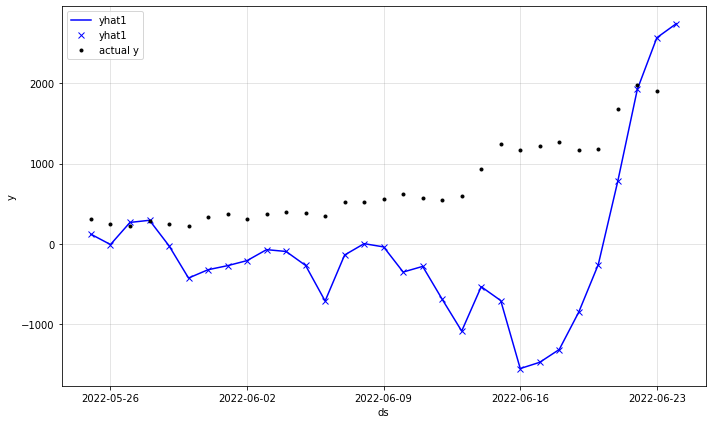

In [29]:
# forecast test data
future = m.make_future_dataframe(
    df=concat_df_event_neural_prophet, 
    events_df=df_event_neural_prophet, 
    n_historic_predictions=True,
)
forecast_in_sample = m.predict(future)

m = m.highlight_nth_step_ahead_of_each_forecast(1)

fig = m.plot(forecast_in_sample)
fig1 = m.plot(forecast_in_sample[-60:])


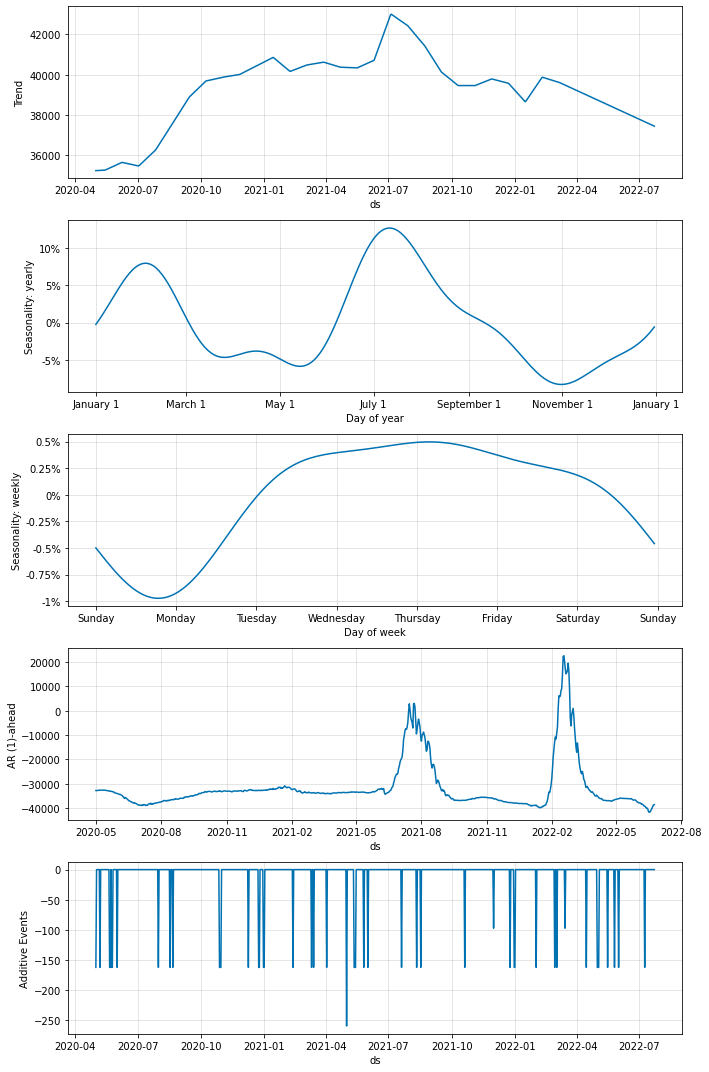

In [30]:
# plot component
fig = m.plot_components(forecast_in_sample)

In [31]:
actuals = concat_df_event_neural_prophet['y']
predictions = forecast_in_sample['yhat1'][:-31].fillna(0)

In [228]:
print(actuals.to_markdown())

|     |     y |
|----:|------:|
|   0 |     2 |
|   1 |     0 |
|   2 |     0 |
|   3 |     0 |
|   4 |     2 |
|   5 |     0 |
|   6 |     2 |
|   7 |    13 |
|   8 |     8 |
|   9 |     0 |
|  10 |    35 |
|  11 |    27 |
|  12 |    21 |
|  13 |    17 |
|  14 |    38 |
|  15 |    55 |
|  16 |    82 |
|  17 |    60 |
|  18 |    81 |
|  19 |    64 |
|  20 |    65 |
|  21 |   106 |
|  22 |   105 |
|  23 |   103 |
|  24 |   153 |
|  25 |   109 |
|  26 |   130 |
|  27 |   129 |
|  28 |   114 |
|  29 |   149 |
|  30 |   113 |
|  31 |   196 |
|  32 |   106 |
|  33 |   181 |
|  34 |   218 |
|  35 |   247 |
|  36 |   218 |
|  37 |   337 |
|  38 |   219 |
|  39 |   330 |
|  40 |   399 |
|  41 |   316 |
|  42 |   282 |
|  43 |   297 |
|  44 |   380 |
|  45 |   407 |
|  46 |   325 |
|  47 |   327 |
|  48 |   185 |
|  49 |   375 |
|  50 |   283 |
|  51 |   357 |
|  52 |   436 |
|  53 |   396 |
|  54 |   275 |
|  55 |   214 |
|  56 |   415 |
|  57 |   260 |
|  58 |   347 |
|  59 |   433 |
|  60 | 

In [229]:
print(predictions.to_markdown())

|     |       yhat1 |
|----:|------------:|
|   0 |   890.31    |
|   1 |   943.806   |
|   2 |   952.167   |
|   3 |   947.033   |
|   4 |   913.214   |
|   5 |   871.933   |
|   6 |   795.471   |
|   7 |   720.626   |
|   8 |   763.358   |
|   9 |   721.405   |
|  10 |   660.698   |
|  11 |   595.106   |
|  12 |   489.708   |
|  13 |   391.504   |
|  14 |   444.596   |
|  15 |   430.167   |
|  16 |   402.342   |
|  17 |   338.02    |
|  18 |   271.623   |
|  19 |  -751.474   |
|  20 |    62.4565  |
|  21 |   148.656   |
|  22 |  -755.965   |
|  23 |   150.364   |
|  24 |   102.51    |
|  25 |    53.5635  |
|  26 |   -47.5335  |
|  27 |  -132.897   |
|  28 |     3.56773 |
|  29 |    45.6502  |
|  30 |    70.9684  |
|  31 |    46.2611  |
|  32 |    20.0869  |
|  33 |   -68.0021  |
|  34 |  -138.013   |
|  35 |    50.4242  |
|  36 |   125.99    |
|  37 |   179.726   |
|  38 |  -739.129   |
|  39 |   162.58    |
|  40 |    78.3721  |
|  41 |    12.7536  |
|  42 |   240.534   |
|  43 |   

In [ ]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=concat_df_event_neural_prophet['ds'], y=concat_df_event_neural_prophet['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['yhat1'], name='Predicted',))
# fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['event_covidVariantNeuralProphet'], name='Covid Variant',))
# fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['event_hariRayaNeuralProphet'], name='Hari Raya',))

fig.show()

In [33]:
# Neural Prophet
from statsmodels.tools.eval_measures import rmse, meanabs, mse

print(f"RMSE: {(rmse(actuals, predictions))}")
# print(f"MSE: {(mse(actuals, predictions))}")
print(f"MAE: {(meanabs(actuals, predictions))}")
# print(f"MAPE: {(np.round(np.mean(np.abs(100*actuals/predictions)), 0))} %")

RMSE: 2040.502196898727
MAE: 941.7300437234899


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.763% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /Users/efraimwijaya/Developer/github/skripsi-forecasting-neural-prophet/new-neural-prophet/neural_prophet/neuralprophet/forecaster.py:1665: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /Users/efraimwijaya/Developer/github/skripsi-forecasting-neural-prophet/new-neural-prophet/neural_

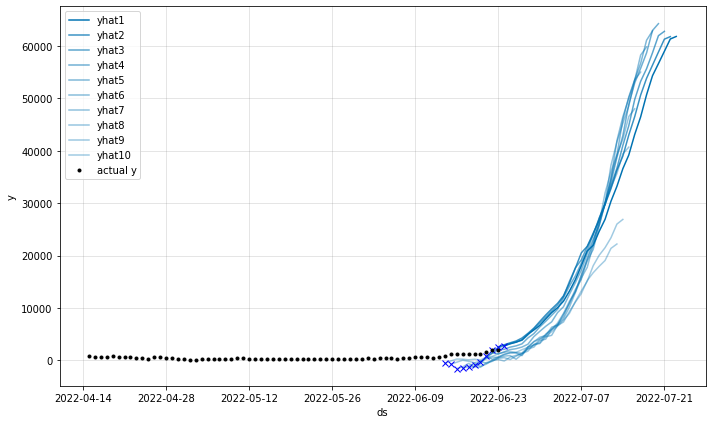

In [34]:
# predict out-sample datasets
future = m.make_future_dataframe(
    df=concat_df_event_neural_prophet,
    events_df=df_event_neural_prophet,
    n_historic_predictions=10
)
forecast_out_sample = m.predict(df=future)
fig = m.plot(forecast_out_sample)

## 8.2 Facebook Prophet

In [294]:
params_facebook_prophet = {
    # trend
    'n_changepoints' : 30, 
    'changepoint_prior_scale' : 0.5,

    # seasonality
    'yearly_seasonality' : True,
    'weekly_seasonality' : True,
    'daily_seasonality' : False,
    'seasonality_mode' : 'multiplicative', 
    # 'seasonality_prior_scale' : 5,
    
    # event
    'holidays' : df_event_facebook_prophet,
    'holidays_prior_scale' : 0.05,

}

In [295]:
# set all param to model
m = Prophet(
    **params_facebook_prophet
)

# fit data train to model
m.fit(df)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [296]:
future = m.make_future_dataframe(
    periods=30,
    freq='D',
    # include_history=False,
)

future.tail()

ds
868 2022-07-19
869 2022-07-20
870 2022-07-21
871 2022-07-22
872 2022-07-23

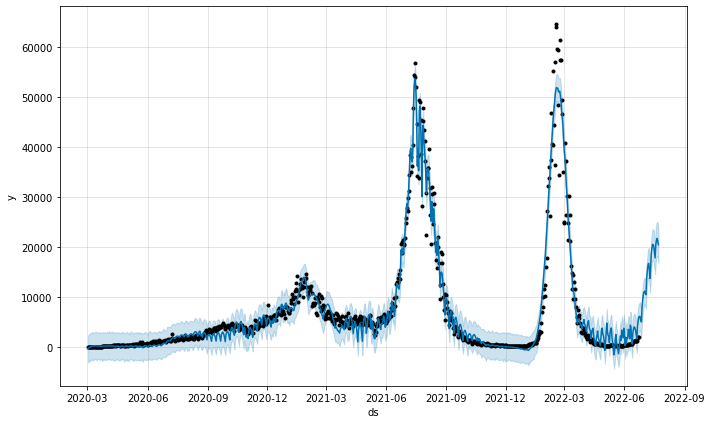

In [297]:
forecast_in_sample = m.predict(future)
fig = m.plot(forecast_in_sample)

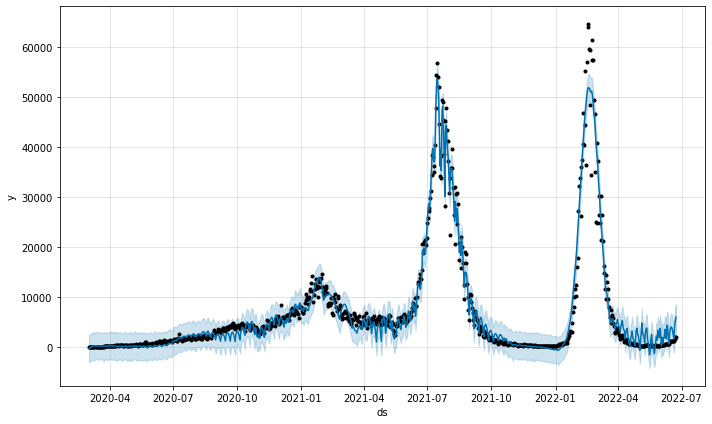

In [298]:
fig = m.plot(forecast_in_sample[:-30])

In [299]:
forecast_in_sample.tail()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
868 2022-07-19  33966.091805  17070.321507  23846.037643  31644.719599   
869 2022-07-20  34144.756215  17759.595452  24813.096786  31678.075912   
870 2022-07-21  34323.420625  18271.194415  25017.530543  31634.830647   
871 2022-07-22  34502.085035  17885.264125  24829.843421  31665.566273   
872 2022-07-23  34680.749445  16827.928322  23890.994022  31718.838302   

      trend_upper  covidVariantFacebookProphet  \
868  36416.203071                          0.0   
869  36787.380649                          0.0   
870  37074.180131                          0.0   
871  37394.908041                          0.0   
872  37826.547374                          0.0   

     covidVariantFacebookProphet_lower  covidVariantFacebookProphet_upper  \
868                                0.0                                0.0   
869                                0.0                                0.0   
870                                0.0                                0.0   
871                                0.0                                0.0   
872                                0.0                                0.0   

     hariRayaFacebookProphet  ...    weekly  weekly_lower  weekly_upper  \
868                      0.0  ...  0.005707      0.005707      0.005707   
869                      0.0  ...  0.027279      0.027279      0.027279   
870                      0.0  ...  0.039355      0.039355      0.039355   
871                      0.0  ...  0.027989      0.027989      0.027989   
872                      0.0  ...  0.005978      0.005978      0.005978   

       yearly  yearly_lower  yearly_upper  additive_terms  \
868 -0.402165     -0.402165     -0.402165             0.0   
869 -0.403888     -0.403888     -0.403888             0.0   
870 -0.406920     -0.406920     -0.406920             0.0   
871 -0.411069     -0.411069     -0.411069             0.0   
872 -0.416142     -0.416142     -0.416142             0.0   

     additive_terms_lower  additive_terms_upper          yhat  
868                   0.0                   0.0  20499.968308  
869                   0.0                   0.0  21285.519976  
870                   0.0                   0.0  21707.360160  
871                   0.0                   0.0  21285.009789  
872                   0.0                   0.0  20455.945222  

[5 rows x 28 columns]

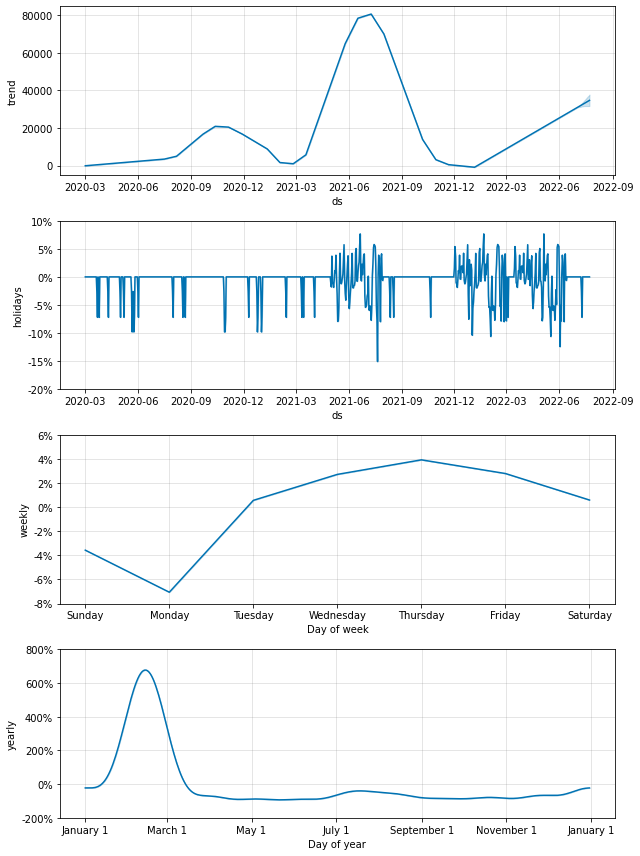

In [300]:
# plot component
fig = m.plot_components(forecast_in_sample)

In [301]:
actuals = df['y']
predictions = forecast_in_sample['yhat'][:-30]

In [302]:
print(actuals.to_markdown())
print(predictions.to_markdown())

|     |     y |
|----:|------:|
|   0 |     2 |
|   1 |     0 |
|   2 |     0 |
|   3 |     0 |
|   4 |     2 |
|   5 |     0 |
|   6 |     2 |
|   7 |    13 |
|   8 |     8 |
|   9 |     0 |
|  10 |    35 |
|  11 |    27 |
|  12 |    21 |
|  13 |    17 |
|  14 |    38 |
|  15 |    55 |
|  16 |    82 |
|  17 |    60 |
|  18 |    81 |
|  19 |    64 |
|  20 |    65 |
|  21 |   106 |
|  22 |   105 |
|  23 |   103 |
|  24 |   153 |
|  25 |   109 |
|  26 |   130 |
|  27 |   129 |
|  28 |   114 |
|  29 |   149 |
|  30 |   113 |
|  31 |   196 |
|  32 |   106 |
|  33 |   181 |
|  34 |   218 |
|  35 |   247 |
|  36 |   218 |
|  37 |   337 |
|  38 |   219 |
|  39 |   330 |
|  40 |   399 |
|  41 |   316 |
|  42 |   282 |
|  43 |   297 |
|  44 |   380 |
|  45 |   407 |
|  46 |   325 |
|  47 |   327 |
|  48 |   185 |
|  49 |   375 |
|  50 |   283 |
|  51 |   357 |
|  52 |   436 |
|  53 |   396 |
|  54 |   275 |
|  55 |   214 |
|  56 |   415 |
|  57 |   260 |
|  58 |   347 |
|  59 |   433 |
|  60 | 

In [303]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['yhat'], name='Predicted',))
# fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['trend'], name='Trend',))
# fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['covidVariantFacebookProphet'], name='Covid Variant',))
# fig.add_trace(go.Scatter(x=forecast_in_sample['ds'], y=forecast_in_sample['hariRayaFacebookProphet'], name='Hari Raya',))
fig.show()

In [304]:
from statsmodels.tools.eval_measures import rmse, meanabs, mse

print(f"RMSE: {(rmse(actuals, predictions))}")
# print(f"MSE: {(mse(actuals, predictions))}")
print(f"MAE: {(meanabs(actuals, predictions))}")
# print(f"MAPE: {(np.round(np.mean(np.abs((actuals - predictions) / actuals)) * 100))} %")
# print(f"MAPE: {(np.round(np.mean(np.abs(100*actuals/predictions)), 0))} %")


RMSE: 2122.165593855983
MAE: 1239.6785620259614
